In [1]:
# importing important libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict

In [2]:
# Note: 50% of the original dataset were randomly selected for analysis. view the Cst_Cnt field to see the randomness

raw_bottle= pd.read_csv('calcofi_sample.csv')
raw_bottle.head(3)

C:\Users\Administrator\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (74) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Cst_Cnt,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,...,R_PHAEO,R_PRES,R_SAMP,DIC1,DIC2,TA1,TA2,pH2,pH1,DIC Quality Comment
0,792850,31635,792851,080.0 070.0,20-0801JD-MX-023-0740-08000700-0002A-3,2,12.07,32.919,6.31,24.961,...,0.25,2,220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,421617,16184,421618,110.0 035.0,19-6904AX-HY-100-0007-11000350-0030A-7,30,13.16,NaN,5.92,NaN,...,NaN,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,614405,25103,614406,057.5 061.0,19-8705NM-10-140-0033-05750610-0011A-3,11,11.26,33.469,5.75,25.537,...,0.25,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Preprocessing the data

In [3]:
# displaying columns for feature engineering

raw_bottle.columns

Index(['Unnamed: 0', 'Cst_Cnt', 'Btl_Cnt', 'Sta_ID', 'Depth_ID', 'Depthm',
       'T_degC', 'Salnty', 'O2ml_L', 'STheta', 'O2Sat', 'Oxy_µmol/Kg',
       'BtlNum', 'RecInd', 'T_prec', 'T_qual', 'S_prec', 'S_qual', 'P_qual',
       'O_qual', 'SThtaq', 'O2Satq', 'ChlorA', 'Chlqua', 'Phaeop', 'Phaqua',
       'PO4uM', 'PO4q', 'SiO3uM', 'SiO3qu', 'NO2uM', 'NO2q', 'NO3uM', 'NO3q',
       'NH3uM', 'NH3q', 'C14As1', 'C14A1p', 'C14A1q', 'C14As2', 'C14A2p',
       'C14A2q', 'DarkAs', 'DarkAp', 'DarkAq', 'MeanAs', 'MeanAp', 'MeanAq',
       'IncTim', 'LightP', 'R_Depth', 'R_TEMP', 'R_POTEMP', 'R_SALINITY',
       'R_SIGMA', 'R_SVA', 'R_DYNHT', 'R_O2', 'R_O2Sat', 'R_SIO3', 'R_PO4',
       'R_NO3', 'R_NO2', 'R_NH4', 'R_CHLA', 'R_PHAEO', 'R_PRES', 'R_SAMP',
       'DIC1', 'DIC2', 'TA1', 'TA2', 'pH2', 'pH1', 'DIC Quality Comment'],
      dtype='object')

In [4]:
# selecting the relevant features. Features dropped ranged from categorical varibles (having no relevant info to the prediction
# of salinity) to reported data like R_Depth and its likes (e.g: Depthm== R_Depth)

new_bottle= raw_bottle[['T_degC', 'Depthm', 'Salnty', 'O2ml_L', 'STheta', 'O2Sat', 'PO4uM', 'SiO3uM', 'NO2uM', 'NO3uM', 'NH3uM',
             'ChlorA', 'Phaeop', 'LightP', 'R_SIGMA', 'R_SVA', 'R_DYNHT', 'R_PRES']]
new_bottle.head(3)

,T_degC,Depthm,Salnty,O2ml_L,STheta,O2Sat,PO4uM,SiO3uM,NO2uM,NO3uM,NH3uM,ChlorA,Phaeop,LightP,R_SIGMA,R_SVA,R_DYNHT,R_PRES
0,12.07,2,32.919,6.31,24.961,103.1,0.49,4.6,0.08,2.3,0.0,0.85,0.25,NaN,24.961,298.6,0.006,2
1,13.16,30,NaN,5.92,NaN,NaN,0.76,4.8,NaN,1.7,NaN,NaN,NaN,NaN,NaN,NaN,0.080,30
2,11.26,11,33.469,5.75,25.537,92.6,1.22,15.7,0.29,12.7,NaN,0.92,0.25,NaN,25.530,243.9,0.020,11


In [5]:
# shape of new_dataset (18 columns selected from 74)

new_bottle.shape

(400000, 18)

In [6]:
# check for missing values. 

new_bottle.isnull().sum()

T_degC       5078
Depthm          0
Salnty      21902
O2ml_L      77815
STheta      24357
O2Sat       93971
PO4uM      208822
SiO3uM     236184
NO2uM      243742
NO3uM      243846
NH3uM      370108
ChlorA     295731
Phaeop     295728
LightP     391351
R_SIGMA     24445
R_SVA       24410
R_DYNHT     21620
R_PRES          0
dtype: int64

In [7]:
# replacing the missing values with the mean of the observed variables. Apart from Depthm and R_PRES, others have missing values

cols= ['T_degC', 'Depthm', 'Salnty', 'O2ml_L', 'STheta', 'O2Sat', 'PO4uM', 'SiO3uM', 'NO2uM', 'NO3uM', 'NH3uM',
             'ChlorA', 'Phaeop', 'LightP', 'R_SIGMA', 'R_SVA', 'R_DYNHT', 'R_PRES']

new_bottle[cols]= new_bottle[cols].fillna(new_bottle.mean())

C:\Users\Administrator\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [8]:
# check for missing values

new_bottle.isnull().sum()

T_degC     0
Depthm     0
Salnty     0
O2ml_L     0
STheta     0
O2Sat      0
PO4uM      0
SiO3uM     0
NO2uM      0
NO3uM      0
NH3uM      0
ChlorA     0
Phaeop     0
LightP     0
R_SIGMA    0
R_SVA      0
R_DYNHT    0
R_PRES     0
dtype: int64

In [9]:
print(new_bottle.shape)
new_bottle

(400000, 18)


,T_degC,Depthm,Salnty,O2ml_L,STheta,O2Sat,PO4uM,SiO3uM,NO2uM,NO3uM,NH3uM,ChlorA,Phaeop,LightP,R_SIGMA,R_SVA,R_DYNHT,R_PRES
0,12.07,2,32.919000,6.310000,24.961000,103.100000,0.490000,4.600000,0.08000,2.300000,0.000000,0.850000,0.250000,18.637732,24.961000,298.600000,0.006,2
1,13.16,30,33.839786,5.920000,25.818542,57.136832,0.760000,4.800000,0.04245,1.700000,0.083992,0.446564,0.198739,18.637732,25.810664,221.031633,0.080,30
2,11.26,11,33.469000,5.750000,25.537000,92.600000,1.220000,15.700000,0.29000,12.700000,0.083992,0.920000,0.250000,18.637732,25.530000,243.900000,0.020,11
3,8.27,200,34.118000,1.850000,26.544000,28.000000,2.360000,42.800000,0.01000,30.600000,0.083992,0.010000,0.020000,18.637732,26.540000,151.800000,0.430,201
4,5.21,700,34.420000,0.330000,27.198000,4.700000,1.563237,26.579764,0.04245,17.289046,0.083992,0.446564,0.198739,18.637732,27.190000,94.800000,1.050,705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,12.60,99,32.970000,5.780000,24.902000,95.500000,1.563237,26.579764,0.04245,17.289046,0.083992,0.446564,0.198739,18.637732,24.900000,306.700000,0.380,99
399996,5.93,400,34.110000,0.980000,26.863000,14.000000,2.940000,71.600000,0.01000,39.100000,0.083992,0.446564,0.198739,18.637732,26.860000,123.300000,0.820,403
399997,19.04,0,33.420000,5.580000,23.805000,105.100000,1.563237,26.579764,0.04245,17.289046,0.083992,0.446564,0.198739,18.637732,23.800000,408.600000,0.000,0
399998,6.38,459,34.220000,0.450000,26.893000,6.500000,1.563237,26.579764,0.04245,17.289046,0.083992,0.446564,0.198739,18.637732,26.890000,121.800000,0.830,462


C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  """


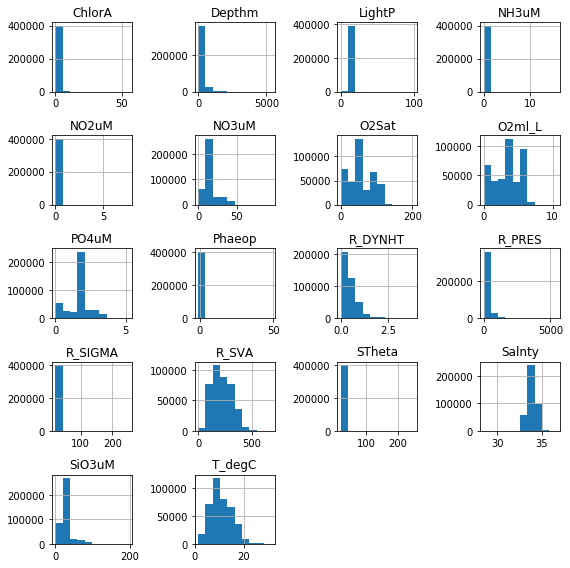

In [10]:
# Data Visualization to check for normality

fig = plt.figure(figsize = (8,8))
ax = fig.gca()
new_bottle.hist(ax = ax)
plt.tight_layout()

# There is some degree of normality within some features and the target variable (Salnty)
# while some features showed signs of being otherwise. I will Proceed without fixing for now**

#### Processing: Splitting and Normalization

In [11]:
# Splitting datasets into train and test sets

X= new_bottle[['T_degC', 'Depthm', 'O2ml_L', 'STheta', 'O2Sat', 'PO4uM', 'SiO3uM', 'NO2uM', 'NO3uM', 'NH3uM',
             'ChlorA', 'Phaeop', 'LightP', 'R_SIGMA', 'R_SVA', 'R_DYNHT', 'R_PRES']]

y= new_bottle['Salnty']

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, random_state= 1)

print ('X_train_shape: {}'. format(X_train.shape))
print ('y_train_shape: {}'. format(y_train.shape))
print ('X_test_shape: {}'. format(X_test.shape))
print ('y_test_shape: {}'. format(y_test.shape))

X_train_shape: (320000, 17)
y_train_shape: (320000,)
X_test_shape: (80000, 17)
y_test_shape: (80000,)


In [12]:
# Normalizing X_train & X_test using MinMaxScaler

scaler= MinMaxScaler()

# fit_transforming X_train

norm_X_train= scaler.fit_transform(X_train)
norm_X_train

array([[0.33490725, 0.03872217, 0.53653654, ..., 0.33089312, 0.15104167,
        0.03818389],
       [0.31579835, 0.        , 0.65165165, ..., 0.32303314, 0.        ,
        0.        ],
       [0.24586847, 0.05227493, 0.19119119, ..., 0.24011713, 0.18229167,
        0.05148176],
       ...,
       [0.22192243, 0.05208132, 0.14714715, ..., 0.21273792, 0.125     ,
        0.05148176],
       [0.45564924, 0.        , 0.55955956, ..., 0.51522694, 0.        ,
        0.        ],
       [0.08128162, 0.19361084, 0.34075658, ..., 0.11156662, 0.35416667,
        0.19148936]])

In [13]:
# Transforming X_test

norm_X_test= scaler.transform(X_test)
norm_X_test

array([[0.90421585, 0.00968054, 0.27227227, ..., 0.79062958, 0.0703125 ,
        0.00949848],
       [0.25193929, 0.0338819 , 0.34075658, ..., 0.25578331, 0.12239583,
        0.03343465],
       [0.51568297, 0.01452081, 0.57057057, ..., 0.49136164, 0.06770833,
        0.01424772],
       ...,
       [0.20337268, 0.08615682, 0.02502503, ..., 0.17452416, 0.1953125 ,
        0.08510638],
       [0.52580101, 0.00193611, 0.51351351, ..., 0.50849195, 0.0078125 ,
        0.0018997 ],
       [0.18819562, 0.07744434, 0.07807808, ..., 0.19238653, 0.1953125 ,
        0.07655775]])

#### modeling

In [14]:
# Case1: using Linear Regression

reg= LinearRegression()
reg.fit(norm_X_train, y_train)

LinearRegression()

In [15]:
# prediction 

y_pred= reg.predict(norm_X_test)
df1 = pd.DataFrame({'Actual_1': y_test, 'Predicted_1': y_pred})
df1

,Actual_1,Predicted_1
164217,35.176,34.000772
136326,33.928,33.896727
139035,33.713,33.655129
184089,34.182,34.251219
49577,33.580,33.648607
...,...,...
356732,33.460,33.484910
298300,34.075,33.972909
342305,34.450,34.479735
246290,33.618,33.628199


In [16]:
# R-squared

r2= r2_score(y_test, y_pred)
round(r2, 3)

0.878

In [17]:
# MSE 

mse= mean_absolute_error(y_test, y_pred)
round(mse, 3)

0.085

In [18]:
# case 2: Using Decision Trees

reg_dec= DecisionTreeRegressor(max_depth= 2)
reg_dec.fit(norm_X_train, y_train)

DecisionTreeRegressor(max_depth=2)

In [19]:
# prediction 

y_pred2= reg_dec.predict(norm_X_test)
df_dec = pd.DataFrame({'Actual_2': y_test, 'Predicted_2': y_pred2})
df_dec

,Actual_2,Predicted_2
164217,35.176,33.662715
136326,33.928,34.089446
139035,33.713,33.363020
184089,34.182,34.322434
49577,33.580,33.662715
...,...,...
356732,33.460,33.662715
298300,34.075,34.322434
342305,34.450,34.322434
246290,33.618,33.662715


In [20]:
# R-squared

r2= r2_score(y_test, y_pred2)
round(r2, 3)

0.586

In [21]:
# MSE 

mse= mean_absolute_error(y_test, y_pred2)
round(mse, 3)

0.195

In [22]:
# case 3: Using cross validation

cross_val_score(reg, X, y, cv=10, scoring = 'r2').mean()

0.8769026636399191

In [23]:
# r-square

reg.score(norm_X_train, y_train) 

0.8766823351325043